In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import pickle
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir('/Users/awxlong/Desktop/my-studies/hpc_exps/')

In [3]:
from HistoMIL.DATA.Slide.concepts.feature import Features
from HistoMIL.EXP.paras.env import EnvParas


/Users/awxlong/anaconda3/envs/biomedai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
preprocess_env = EnvParas()

machine_cohort_loc = "/Users/awxlong/Desktop/my-studies/hpc_exps/User/CRC_machine_config.pkl"
with open(machine_cohort_loc, "rb") as f:   # Unpickling
    [data_locs,exp_locs,machine,user] = pickle.load(f)
preprocess_env.data_locs = data_locs
preprocess_env.exp_locs = exp_locs

In [5]:
preprocess_env.collector_para.feature

FeatureParas(model_name='resnet18', device='mps', trans=<function only_naive_transforms at 0x354469700>, batch_size=32, cluster_nb=200, with_semantic_shifts=False)

In [6]:
clinical_root = "/Users/awxlong/Desktop/my-studies/temp_data/COAD/Feature/clinical/"


In [7]:
# feature_importances = []
# cv_scores_f1 = []
# cv_scores_auc = []
# exclude_columns = ['g0_arrest', 'PatientID']
# ensemble_test_preds = []
# for fold in os.listdir(clinical_root):

#     if fold.startswith('cv'):
#         rf_model = RandomForestClassifier(random_state=42)
#         train_df = pd.read_csv(os.path.join(clinical_root, fold, 'train.csv'))
#         train_df.drop(columns=['Unnamed: 0'], inplace=True)
#         train_df.drop_duplicates(inplace=True)
#         X_train, y_train = train_df.loc[:, ~train_df.columns.isin(exclude_columns)].values, train_df.loc[:, 'g0_arrest'].values
#         rf_model.fit(X_train, y_train)
#         # Get feature importances
#         importances = rf_model.feature_importances_
        
#         val_df = pd.read_csv(os.path.join(clinical_root, fold, 'validation.csv'))
#         val_df.drop(columns=['Unnamed: 0'], inplace=True)
#         val_df.drop_duplicates(inplace=True)
#         X_val, y_val = val_df.loc[:, ~val_df.columns.isin(exclude_columns)].values, val_df.loc[:, 'g0_arrest'].values
#         y_pred_val = rf_model.predict_proba(X_val)[:, 1]
#         y_pred_val_binarized = (y_pred_val > 0.5).astype(int)
#         feature_importances.append(importances)
#         cv_scores_f1.append(f1_score(y_val, y_pred_val_binarized))
#         cv_scores_auc.append(roc_auc_score(y_val, y_pred_val))

#     # if fold.startswith('test'):
#         test_df = pd.read_csv(os.path.join(clinical_root, 'test', 'test.csv'))
#         test_df.drop(columns=['Unnamed: 0'], inplace=True)
#         test_df.drop_duplicates(inplace=True)
#         X_test, y_test = test_df.loc[:, ~test_df.columns.isin(exclude_columns)].values, test_df.loc[:, 'g0_arrest'].values
#         y_pred_test = rf_model.predict_proba(X_test)[:, 1]
#         ensemble_test_preds.append(y_pred_test)

In [39]:
test_df = pd.read_csv(os.path.join(clinical_root, 'test', 'test.csv'))
# test_df.to_csv('test_set.csv')
test_df.shape

(58, 30)

In [62]:
[col for col in test_df.columns if col.startswith('Pathologic')]
# [col for col in test_df.columns]

['Pathologic Stage_Stage II',
 'Pathologic Stage_Stage IIA',
 'Pathologic Stage_Stage IIB',
 'Pathologic Stage_Stage III',
 'Pathologic Stage_Stage IIIB',
 'Pathologic Stage_Stage IIIC',
 'Pathologic Stage_Stage IV',
 'Pathologic Stage_Stage IVA']

In [43]:
early_stage_mask = (
    (test_df['Pathologic Stage_Stage II'] == 1) |
    (test_df['Pathologic Stage_Stage IIA'] == 1) |
    (test_df['Pathologic Stage_Stage IIB'] == 1)
)

# Get Early Stage Patient IDs
early_stage_patient_ids = test_df.loc[early_stage_mask,  ['PatientID', 'g0_arrest']].drop_duplicates()

# Create a mask for Late Stage Patients
late_stage_mask = (
    (test_df['Pathologic Stage_Stage III'] == 1) |
    (test_df['Pathologic Stage_Stage IIIB'] == 1) |
    (test_df['Pathologic Stage_Stage IIIC'] == 1) |
    (test_df['Pathologic Stage_Stage IV'] == 1) |
    (test_df['Pathologic Stage_Stage IVA'] == 1)
)

# Get Late Stage Patient IDs
late_stage_patient_ids = test_df.loc[late_stage_mask, ['PatientID', 'g0_arrest']].drop_duplicates()

# Output the results
print("Early Stage PatientIDs:")
print(early_stage_patient_ids)

print("\nLate Stage PatientIDs:")
print(late_stage_patient_ids)

# Combine early and late stage patient IDs with their labels
combined_df = pd.concat([early_stage_patient_ids, late_stage_patient_ids])

# Create a new column to indicate the stage
combined_df['Stage'] = combined_df.apply(
    lambda row: 'Early' if row['PatientID'] in (early_stage_patient_ids['PatientID'].values) else 'Late',
    axis=1
)

Early Stage PatientIDs:
       PatientID  g0_arrest
0   TCGA-AD-6963          0
2   TCGA-AY-6197          0
3   TCGA-D5-6536          1
4   TCGA-5M-AAT5          1
5   TCGA-CM-6679          0
7   TCGA-5M-AATE          1
8   TCGA-DM-A28G          1
10  TCGA-CK-6746          0
16  TCGA-AA-A022          1
17  TCGA-AA-3555          1
18  TCGA-A6-2676          1
19  TCGA-DM-A1DB          1
20  TCGA-DM-A282          1
23  TCGA-AA-A00K          1
24  TCGA-CK-5913          0
26  TCGA-AA-A01Q          1
27  TCGA-CA-6717          0
30  TCGA-DM-A28K          1
34  TCGA-DM-A1D8          1
36  TCGA-AA-3655          1
37  TCGA-G4-6626          1
38  TCGA-A6-6141          1
40  TCGA-DM-A0XD          1
41  TCGA-EI-6507          0
47  TCGA-AH-6544          1
52  TCGA-EI-6506          0
56  TCGA-CL-5918          0

Late Stage PatientIDs:
       PatientID  g0_arrest
1   TCGA-AZ-6600          0
9   TCGA-5M-AAT4          1
11  TCGA-AA-A02E          0
12  TCGA-A6-A567          0
13  TCGA-AA-3684          0


In [46]:
print(combined_df.shape)
print(combined_df.head())
print(combined_df.tail())

(50, 3)
      PatientID  g0_arrest  Stage
0  TCGA-AD-6963          0  Early
2  TCGA-AY-6197          0  Early
3  TCGA-D5-6536          1  Early
4  TCGA-5M-AAT5          1  Early
5  TCGA-CM-6679          0  Early
       PatientID  g0_arrest Stage
49  TCGA-AG-3727          1  Late
50  TCGA-AG-3583          1  Late
51  TCGA-AG-4021          1  Late
53  TCGA-AF-2690          0  Late
55  TCGA-AH-6643          0  Late


In [57]:
pids = [pid for pid in test_df['PatientID'] if pid not in combined_df['PatientID'].values]
test_df[test_df['PatientID'].isin(pids)].loc[:, ['PatientID', 'g0_arrest']]

,PatientID,g0_arrest
6,TCGA-AZ-5407,1
21,TCGA-AA-3549,0
22,TCGA-AA-3854,1
28,TCGA-CM-5864,1
29,TCGA-AA-3877,0
44,TCGA-AG-3726,1
54,TCGA-DC-6158,0
57,TCGA-AF-6655,0


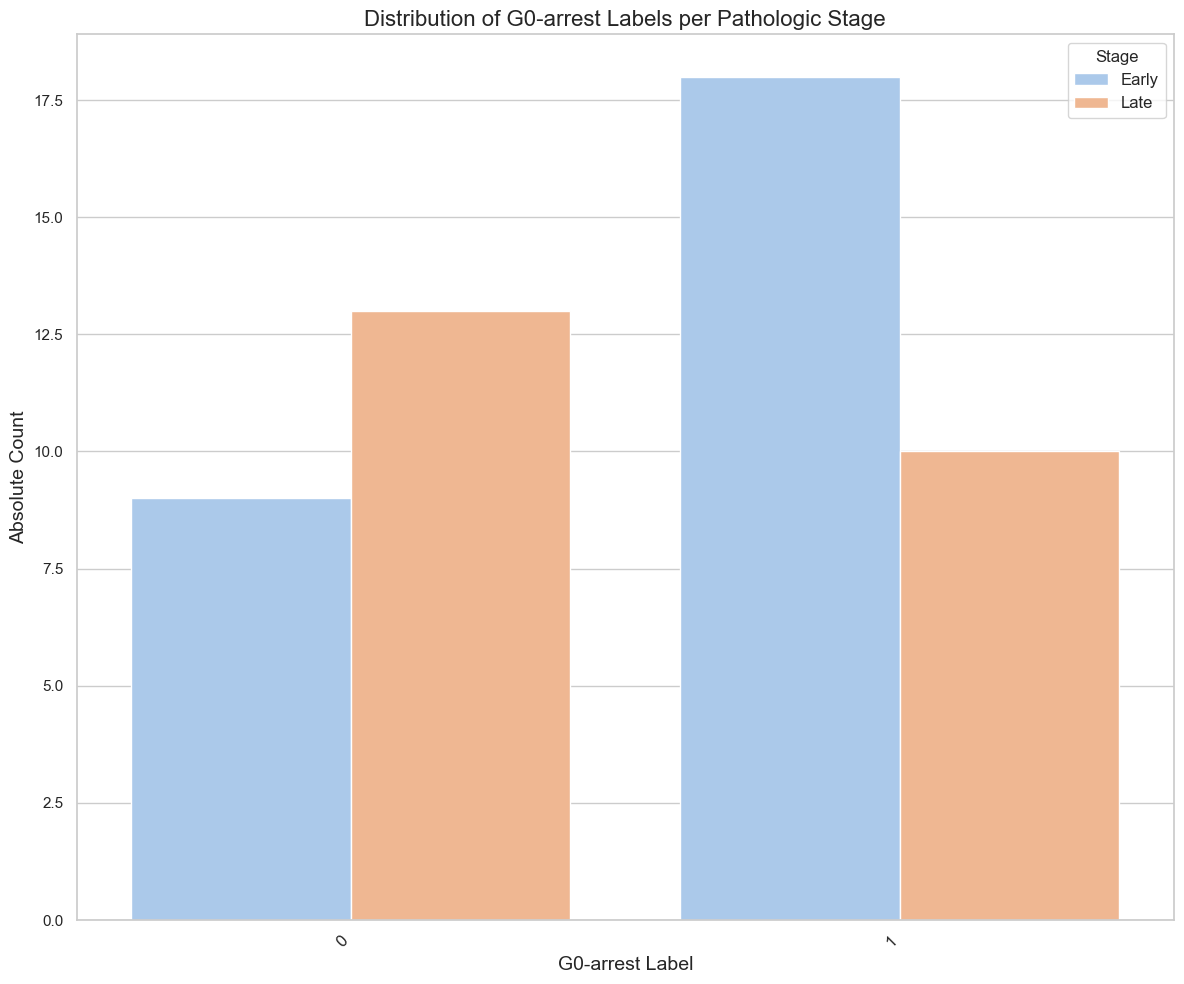

In [33]:


# Set the aesthetics for the plot
plt.figure(figsize=(12, 10))
sns.set_theme(style="whitegrid")

# Create a count plot to visualize the distribution of G0-arrest labels per pathologic stage
sns.countplot(x='g0_arrest', hue='Stage', data=combined_df, palette='pastel')

# Customize the plot with titles and labels
plt.title('Distribution of G0-arrest Labels per Pathologic Stage', fontsize=16)
plt.xlabel('G0-arrest Label', fontsize=14)
plt.ylabel('Absolute Count', fontsize=14)
plt.legend(title='Stage', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()